# Recommendation Systems Assignment: Collaborative Filtering

### CSCI 6517 Recommender System

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
!pip install numpy
!pip install pandas
!pip install tqdm
!pip install scikit-learn


In [2]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

## Support functions and variables

In [3]:
import zipfile
import os

zip_path = 'ml-100k.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
MOVIELENS_DIR = "ml-100k"

In [5]:
print(os.listdir(MOVIELENS_DIR))

['allbut.pl', 'mku.sh', 'README', 'u.data', 'u.genre', 'u.info', 'u.item', 'u.occupation', 'u.user', 'u1.base', 'u1.test', 'u2.base', 'u2.test', 'u3.base', 'u3.test', 'u4.base', 'u4.test', 'u5.base', 'u5.test', 'ua.base', 'ua.test', 'ub.base', 'ub.test']


In [6]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [7]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users (rows) :", num_users)
print("Number of items (columns) :", num_items)

Number of users (rows) : 943
Number of items (columns) : 1682


## Q1 Data Preprocessing and Baseline algorithms

### (a)

Data in recommendation systems is usually encoded as data frame with three or more columns:  (user, item, rating, additional meta-data if present). Complete the function dataPreprocessor that takes the data frame, total number of users, total number of items and it should output a user-item matrix as demonstrated in the lab. See the function comments for more guidance. The following experiments will all use dataPreprocessor.

In [9]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    #initializing a matrix with userxitems size
    matrix = np.zeros((num_users, num_items), dtype=np.int8)

    #populating each entries with ratings
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
       
    ###########         end         ###########
    return matrix

In [10]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

In [11]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

Making the train and test matrix

In [12]:
train_df = getData(MOVIELENS_DIR, 'u1.base')
test_df = getData(MOVIELENS_DIR, 'u1.test')

# test number of records (total should be 100K)
print("Dimension of train:", train_df.shape)
print("# of lines in train:", train_df.shape[0])
print("Dimension of test:", test_df.shape)
print("# of lines in test:", test_df.shape[0])

Dimension of train: (80000, 4)
# of lines in train: 80000
Dimension of test: (20000, 4)
# of lines in test: 20000


In [13]:
trainUserItemMatrix = dataPreprocessor(train_df, num_users, num_items)
testUserItemMatrix = dataPreprocessor(test_df, num_users, num_items)

In [14]:
#inspecting train matrix
trainUserItemMatrix

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

In [15]:
trainUserItemMatrix.shape

(943, 1682)

In [16]:
testUserItemMatrix.shape

(943, 1682)

### (b)

 In this question, we’ll port the baseline algorithms from the lab to our evaluation framework for the assignment. To do so, you need to implement the two baseline algorithms (popularity,
 user average rating). Please fill in the indicated functions(`popularity`, `useraverage`) in class `BaseLineRecSys`; see comments there for more guidance. The rest of `BaseLineRecSys` has been written for you.

In [17]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))
        
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # Extract the items the user already rated
                userVector = train_matrix[user, :]
                ratedItems = userVector[userVector.nonzero()]
            
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user, item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
    
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print("calculated %d users" % (user,))
        
        print("Max item popularity score:", np.max(itemPopularity))
        return predictionMatrix
 
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [18]:
popularity_recsys = BaseLineRecSys('popularity')

In [19]:
popularity_recsys.predict_all(train_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


In [20]:
x = popularity_recsys.getModel()

In [21]:
print(np.all(x<=1))

True


In [22]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [23]:
popularity_recsys.evaluate_test(test_df, copy=True).head()

20000it [00:03, 6501.68it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [24]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [25]:
average_user_rating_recsys.predict_all(train_df, num_users, num_items)

In [26]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [27]:
average_user_rating_recsys.evaluate_test(test_df, copy=True).head()

0it [00:00, ?it/s]

20000it [00:02, 6963.37it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Q2 Similarity in Collaborative Filtering

### (a)

In class SimBasedRecSys, there are two similarity measurement functions (`cosine`, `euclidean`). Please fill in the missing part of those functions. Be careful how you convert Euclidean distance to a [0,1] similarity for use in the recommender. This implementation is very short and should use pairwise distance. (Google for “pairwise distance scikit learn” for a list of distance metrics, more Googling will tell you what they mean.) Which metric works better? Why?

In [28]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base + '-' + self.method_name

    def _getMethod(self, method_name):
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'manhattan': self.manhattan,
            'chebyshev': self.chebyshev
        }
        return switcher[method_name]

    @staticmethod
    def cosine(matrix):
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix

    @staticmethod
    def euclidean(matrix):
        distance_matrix = pairwise_distances(matrix, metric='euclidean')
        similarity_matrix = 1 / (1 + distance_matrix)
        return similarity_matrix

    @staticmethod
    def manhattan(matrix):
        distance_matrix = pairwise_distances(matrix, metric="manhattan")
        similarity_matrix = 1 / (1 + distance_matrix)
        return similarity_matrix

    @staticmethod
    def chebyshev(matrix):
        distance_matrix = pairwise_distances(matrix, metric='chebyshev')
        similarity_matrix = 1 / (1 + distance_matrix)
        return similarity_matrix

    def predict_all(self, train_df, num_users, num_items):
        train_matrix = self.processor(train_df, num_users, num_items)
        rated_mask = (train_matrix > 0).astype(int)

        if self.base == 'user':
            similarity_matrix = self.method(train_matrix)
            numerators = similarity_matrix @ train_matrix
            denominators = similarity_matrix @ rated_mask
            denominators[denominators == 0] = 1e-5
            prediction_matrix = numerators / denominators
            user_avg = np.sum(train_matrix, axis=1) / np.sum(rated_mask, axis=1)
            item_sums = np.sum(prediction_matrix, axis=0)
            prediction_matrix[:, item_sums == 0] += np.expand_dims(user_avg, axis=1)

        elif self.base == 'item':
            similarity_matrix = self.method(train_matrix.T)
            numerators = train_matrix @ similarity_matrix
            denominators = rated_mask @ similarity_matrix
            denominators[denominators == 0] = 1e-5
            prediction_matrix = numerators / denominators
            user_avg = np.sum(train_matrix, axis=1) / np.sum(rated_mask, axis=1)
            item_sums = np.sum(prediction_matrix, axis=0)
            prediction_matrix[:, item_sums == 0] += np.expand_dims(user_avg, axis=1)

        else:
            print('No other option available')
            return

        self.__model = prediction_matrix
        self.__similarity = similarity_matrix  # Store similarity for access later

    def evaluate_test(self, test_df, copy=False):
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan

        for (index, userID, itemID) in tqdm(prediction[['userID', 'itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID - 1, itemID - 1]

        return prediction

    def getModel(self):
        return self.__model

    def getSimilarity(self):
        return self.__similarity  # Getter for similarity matrix

    def getPredColName(self):
        return self.pred_column_name

    def reset(self):
        try:
            self.model = None
        except:
            print("You do not have model..")

In [29]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [30]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [31]:
SimBasedRecSys.manhattan(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

In [32]:
SimBasedRecSys.chebyshev(I)

array([[1. , 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 1. ]])

I think the `cosine similarity` works better for collaborative filtering because it can capture preference patterns regardless of individual rating scales. Also, the `rating matrix` tends to be **sparse** and **high-dimensional** which is a good use case of `cosine similarity`. The `euclidean similarity` only focuses on absolute rating differences whic is misleading when users have different rating habits. But such users with different rating bias may still prefer similar movies, which can only be captured using cosine similarity as **it only concerns the angles** between the two user/ items. For the same reason, `cosine similarity` also outperforms `manhattan similarity` which calculates the absolute difference (i.e. magnitutde).

In short, the phenomena of **scale invariance**, **sparse data robustnesss**, and **vector interpretation** makes `cosine similarity` more preferable compared to the other metrics. 

### (b)

Implement an additional third metric in function `somethingelse` (your choice, see other offerings of pairwise distance) and justify in a sentence why you think this could be a good similarity metric for user or item comparison in collaborative filtering.

I tried `manhattan similarity` and `chebyshev similarity`. Still I think none of these two can be a better choice compared to `cosine similarity` because:
 *  `manhattan similarity` is sensitive to rating scale difference (not scale invarient)
 *  `chebyshev similarity` is overlay conservative and may miss certain nuanced disagrements between two users/items that will impact the ranking later on

## Q3 Collaborative Filtering

### (a)

Leveraging the user-user collaborative filtering example from lab, **implement user-user and item-item based collaborative filtering algorithms** by filling out the `predict_all` function in
 class `SimBasedRecSys`. Note that you should implement vectorized versions of collaborative filtering (example give in lab) since loop-based versions will take excessively long to run.

the `predict_all` function was implemented in the above cell containing `SimBasedRecSys` class. Now we are using it.

In [33]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [34]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [35]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [36]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [37]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:14, 7041.04it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


### (b)

Please use the given class `CrossValidation` to report comparative `RMSE` results (averages and confidence intervals) between `user-user` and `item-item` based collaborative filtering for
 cosine similarity. Can you explain why one method may have performed better? Consider the average number of ratings per user and the average number of ratings per item when you state your answer.

In [38]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrieved
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [39]:
# How to use CrossValidation Class?

In [40]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys]

In [41]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_patk = CrossValidation('P@K')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 7235.71it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 7318.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:03, 5813.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 7367.37it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 7544.81it/s]


Processing algorithm useraverage


20000it [00:02, 7783.51it/s]
20000it [00:02, 8430.54it/s]


Using `CrossValidation` to report comparative RMSE results between `user-user` and `item-item`

In [42]:
# 1. Create your algorithm instances
user_cosine_recsys = SimBasedRecSys(base='user', method='cosine')
item_cosine_recsys = SimBasedRecSys(base='item', method='cosine')

In [43]:
# 2. Set up CrossValidation with RMSE metric
cv_rmse = CrossValidation('RMSE')

In [44]:
# 3. Run 5-fold evaluation

algorithm_instances = [user_cosine_recsys, item_cosine_recsys]
results = cv_rmse.run(algorithm_instances, num_users, num_items)

Processing algorithm user-cosine


20000it [00:02, 8293.96it/s]
20000it [00:02, 8756.01it/s]
20000it [00:02, 8850.50it/s]
20000it [00:02, 8675.76it/s]
20000it [00:02, 8434.52it/s]


Processing algorithm item-cosine


20000it [00:02, 8724.84it/s]
20000it [00:02, 8734.11it/s]
20000it [00:02, 8732.29it/s]
20000it [00:02, 8595.63it/s]
20000it [00:02, 8863.63it/s]


In [45]:
# 4. Print results

for model_name, (scores, mean, ci_low, ci_high) in results.items():
    print(f"{model_name}:")
    print(f"  RMSE mean = {mean:.4f}")
    print(f"  95% CI = [{ci_low:.4f}, {ci_high:.4f}]")

user-cosine:
  RMSE mean = 1.0174
  95% CI = [1.0090, 1.0257]
item-cosine:
  RMSE mean = 1.0152
  95% CI = [1.0014, 1.0290]


**Item-based collaborative filtering with `cosine similarity` slightly outperformed user-based CF in terms of `RMSE`**. This is likely because each item receives ratings from many users, producing more stable similarity patterns. In contrast, user preferences tend to vary more and are less reliable for predicting unseen ratings, especially with `cosine similarity` which emphasizes rating pattern alignment over absolute values. It reminds me of an experiment where people randomly guess how many marbles are there in a big jar and they just make wild guess. Turns out, if we just take enough datapoints and average them out, it somewhat approximates to the real number of marbles. Such "aggregation of wisdom" and "reduction of noise" may have contributed similarly in our item-item CF.

Similarly, we can see **item similarities are computed from all users who rated those items** whereas **user similarities depend on individual user's rating history**. Due to such broader consensus of users, item similarity may have been slightly more reliable and thus performed better on `RMSE`. But **it will not still gurantee better ranking, we need further checking user ranking metrics.**

As mentioned in the handout, considering the average number of ratings per user (approx 106 ) and the average number of ratings per item (approx 59). 

* With 1,682 items and ~106 ratings per user, users typically rate 6.302% of all items
* With 943 users and ~59 ratings per item, each item is rated by 6.256% of all users

Which does not actually give me any insight. Rather, in my opinion, it should be more about the overlap of item vs users. I.e., users have less overlap and have distinct taste, whereas, items have more overlap in genre and attract similar users which makes it more reliable for calculating similarity.


## Q4 Performance Comparison

### (a)  Please use the given class `CrossValidation` to compare all the recommenders in Q1, Q2 and Q3 (using cosine similarity) on `RMSE`, `P@k`, and `R@k`. Show the cleanly formatted results of this comparison

In [46]:
popularity_recsys = BaseLineRecSys('popularity')
average_user_rating_recsys = BaseLineRecSys('useraverage')
user_cosine_recsys = SimBasedRecSys(base='user', method='cosine')
item_cosine_recsys = SimBasedRecSys(base='item', method='cosine')

In [47]:
algorithms = [
    popularity_recsys,
    average_user_rating_recsys,
    user_cosine_recsys,
    item_cosine_recsys
]

metrics = ['RMSE', 'P@K', 'R@K']
k = 5  # for precision@k and recall@k

results_summary = {}

for metric in metrics:
    print(f"\n### Evaluating {metric} ###")
    cv = CrossValidation(metric)
    results = cv.run(algorithms, num_users, num_items, k=k if metric != 'RMSE' else None)
    
    # Store results
    results_summary[metric] = results

    # Pretty print
    print(f"\nResults for {metric}:")
    print(f"{'Algorithm':<25} {'Mean':>10} {'95% CI Low':>15} {'95% CI High':>15}")
    for model_name, (scores, mean, ci_low, ci_high) in results.items():
        print(f"{model_name:<25} {mean:10.4f} {ci_low:15.4f} {ci_high:15.4f}")



### Evaluating RMSE ###
Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8631.36it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8810.95it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8551.97it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8567.23it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8929.90it/s]


Processing algorithm useraverage


20000it [00:02, 8888.56it/s]
20000it [00:02, 8602.53it/s]
20000it [00:02, 8884.72it/s]
20000it [00:02, 8967.92it/s]
20000it [00:02, 8635.14it/s]


Processing algorithm user-cosine


20000it [00:02, 8657.81it/s]
20000it [00:02, 8575.32it/s]
20000it [00:02, 8743.89it/s]
20000it [00:02, 8799.86it/s]
20000it [00:02, 8889.20it/s]


Processing algorithm item-cosine


20000it [00:02, 8847.31it/s]
20000it [00:02, 8494.55it/s]
20000it [00:02, 8830.17it/s]
20000it [00:02, 8625.23it/s]
20000it [00:02, 8761.46it/s]



Results for RMSE:
Algorithm                       Mean      95% CI Low     95% CI High
popularity                    3.1591          3.1393          3.1789
useraverage                   1.0437          1.0289          1.0585
user-cosine                   1.0174          1.0090          1.0257
item-cosine                   1.0152          1.0014          1.0290

### Evaluating P@K ###
Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8658.97it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8708.18it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8709.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8909.10it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8680.60it/s]


Processing algorithm useraverage


20000it [00:04, 4351.87it/s]
20000it [00:02, 7113.13it/s]
20000it [00:02, 7164.36it/s]
20000it [00:04, 4987.35it/s]
20000it [00:02, 7303.62it/s]


Processing algorithm user-cosine


20000it [00:05, 3887.84it/s]
20000it [00:07, 2632.62it/s]
20000it [00:09, 2192.86it/s]
20000it [00:06, 2894.38it/s]
20000it [00:02, 7714.05it/s]


Processing algorithm item-cosine


20000it [00:03, 5669.44it/s]
20000it [00:05, 3843.10it/s]
20000it [00:02, 7734.05it/s]
20000it [00:02, 8089.04it/s]
20000it [00:02, 8733.10it/s]



Results for P@K:
Algorithm                       Mean      95% CI Low     95% CI High
popularity                    0.5506          0.4054          0.6957
useraverage                   0.4736          0.3420          0.6053
user-cosine                   0.5558          0.4096          0.7021
item-cosine                   0.5322          0.3837          0.6807

### Evaluating R@K ###
Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:12, 1611.68it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:05, 3631.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8380.53it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8246.03it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


20000it [00:02, 8608.82it/s]


Processing algorithm useraverage


20000it [00:02, 8180.37it/s]
20000it [00:04, 4743.89it/s]
20000it [00:03, 5629.20it/s]
20000it [00:02, 8333.10it/s]
20000it [00:02, 6980.48it/s]


Processing algorithm user-cosine


20000it [00:02, 7937.24it/s]
20000it [00:02, 8183.02it/s]
20000it [00:02, 7826.91it/s]
20000it [00:02, 7708.80it/s]
20000it [00:02, 7928.98it/s]


Processing algorithm item-cosine


20000it [00:02, 8290.56it/s]
20000it [00:02, 8169.41it/s]
20000it [00:02, 8316.73it/s]
20000it [00:02, 7408.07it/s]
20000it [00:02, 8180.30it/s]



Results for R@K:
Algorithm                       Mean      95% CI Low     95% CI High
popularity                    0.4841          0.3671          0.6010
useraverage                   0.4413          0.3293          0.5533
user-cosine                   0.4863          0.3694          0.6031
item-cosine                   0.4750          0.3536          0.5964


### (b) Some baselines cannot be evaluated with some metrics? Which ones and why?

* **Popularity-based Recommender**: Popularity based recomender actually recomends the same product to all user. Evaluating it using `P@K` and `R@K` may actually mean nothing because the recomendations are non-personalized. `RMSE` can be used to calculate the qualities of numerical values of our prediction.
* **User average recommender**: `P@K` and `R@K` can be problematic as all the unseen items are rated the same value (the average for that particular user) which will severly fail in ranking items. To be specific:
  * `P@K` and `R@K` evaluation will be unstable as result varies between runs even for the same training data. This is because all unrated items are predicted the same and from these same values, we have to pick `K` products randomly. In another way, we can say that it is meaningless since there is no such thing as a top-ranked `K` items
  * `RMSE` still can compute the numerical error as it only compares the values between the predicted and the actual ratings, though not helpful for the recomendation rankings of items.  
* **Similarity-based recommenders (user/item)**: This can be evaluated with three of the metrics
  * `RMSE` calculates numerical error between predicted and actual rattings. This does not mean that performance on RMSE makes the recomender a good one.
  * `P@K` and `R@K` helps produce ranked lists
   

### (c) What is the best algorithm for each of `RMSE`, `P@k`, and `R@k`? Can you explain why this may be?

My results give the following

| Metric   | Best Algorithm  | Mean Score | Why It May Be the Best                                                                                              |
| -------- | --------------- | ---------- | ------------------------------------------------------------------------------------------------------------------- |
| `RMSE` | `item_cosine_recsys` | `1.0152`     | Item similarities are more reliable since they **aggregate ratings from different users** and inherently **compensate for individual user rating bias**. Additionally, items with similar characteristics (i.e. movie genres) attract overlapping user groups that may have caused more accurate rating prediction.                 |
| `P@K` | `user_cosine_recsys` | `0.5558`     | User-based collaborative filtering offers more precise ranking **persoalized** to users, exceling at finding users with genuinely similar preferences. It leads to better identification of items (moviess) that users willl actually like as it captures nuanced preference similarities. |
| `R@K` | `user_cosine_recsys` | `0.4863`     | User similarity enables better **coverage of relevant items** by using preference patterns from similar users. This may have enabled them to provide more diverse items that align with user tastes. Such a recomonder system considers the  full preference profiles of similar users which helps it find more relevant items overall.              |


### (d) Does good performance on RMSE imply good performance on ranking metrics and vice versa? Why / why not?

`RMSE` metric implies how similar the predicted and the actual ratings are. But it doesn't guarantee good performance in top-k recommendation metrics like `P@K` or `R@K`. This is becuase `RMS` treats every ratings equally, even for movies that the user may never be recomended. Penalizing our prediction even for the last 1000th movie that actually makes no sense. 

On the other hand, ranking metrics like `P@K` and `R@K` evaluate whether the top-K highest-ranked items are the ones the user actually likes or not instead of treating every prediction with the same importance. This means such metrics penalises only for the top `K` products in the rank and their relevance. Thus, a good `RMSE` may or may not have a good performance on ranking metrics and vice versa.

## Q5. Similarity Evaluation

### (a) Go through the list of movies and pick three not-so-popular movies that you know well. I.e., do not choose “Star Wars” and note that we expect everyone in the class to have chosen different movies. For each of these three movies, list the top 5 most similar movie names according to item-item cosine similarity (you might use a function like numpy argsort).

In [48]:
print(os.listdir(MOVIELENS_DIR))

['allbut.pl', 'mku.sh', 'README', 'u.data', 'u.genre', 'u.info', 'u.item', 'u.occupation', 'u.user', 'u1.base', 'u1.test', 'u2.base', 'u2.test', 'u3.base', 'u3.test', 'u4.base', 'u4.test', 'u5.base', 'u5.test', 'ua.base', 'ua.test', 'ub.base', 'ub.test']


In [49]:
movies_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None,
                        names=['movieID', 'movieTitle'], usecols=[0, 1], index_col=False)
movies_df.head()

,movieID,movieTitle
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [50]:
movies_df.shape

(1682, 2)

Selecting three random movies from the dataset for my task

In [51]:
select_random_movies = lambda df: df.sample(n=3, random_state=None)

movie_1, movie_2, movie_3 = select_random_movies(movies_df).iloc[0], select_random_movies(movies_df).iloc[1], select_random_movies(movies_df).iloc[2]

print(movie_1["movieTitle"])
print(movie_2["movieTitle"])
print(movie_3["movieTitle"])

When We Were Kings (1996)
Á köldum klaka (Cold Fever) (1994)
Jingle All the Way (1996)


Now we use the `item_cosine_recsys`

In [52]:
item_cosine_recsys = SimBasedRecSys(base='item', method='cosine')
item_cosine_recsys.predict_all(train_df, num_users, num_items)

In [53]:
def get_top_5_similar_movies_by_id(movie_id, similarity_matrix, movies_df):
    """
    Given a movie ID, print the top 5 most similar movie titles using the similarity matrix.
    """
    index = movie_id - 1  # Adjust for 0-based index
    similarity_scores = similarity_matrix[index]

    # Exclude itself and get top 5 similar indices
    top_indices = np.argsort(similarity_scores)[::-1]
    top_indices = top_indices[top_indices != index][:5]

    # Convert back to movieIDs
    similar_movie_ids = top_indices + 1

    # Fetch and print titles
    similar_titles = movies_df[movies_df['movieID'].isin(similar_movie_ids)]['movieTitle'].tolist()
    movie_title = movies_df.loc[movies_df['movieID'] == movie_id, 'movieTitle'].values[0]

    print(f"\nTop 5 movies similar to \"{movie_title}\":")
    for title in similar_titles:
        print(f"  - {title}")


In [54]:
# Assuming movie_1, movie_2, movie_3 are Series rows with 'movieID' and 'title'
item_similarity_matrix = item_cosine_recsys.getSimilarity()

get_top_5_similar_movies_by_id(movie_1['movieID'], item_similarity_matrix, movies_df)
get_top_5_similar_movies_by_id(movie_2['movieID'], item_similarity_matrix, movies_df)
get_top_5_similar_movies_by_id(movie_3['movieID'], item_similarity_matrix, movies_df)



Top 5 movies similar to "When We Were Kings (1996)":
  - Grosse Pointe Blank (1997)
  - Donnie Brasco (1997)
  - Last Time I Committed Suicide, The (1997)
  - Female Perversions (1996)
  - Get on the Bus (1996)

Top 5 movies similar to "Á köldum klaka (Cold Fever) (1994)":
  - Collectionneuse, La (1967)
  - Silence of the Palace, The (Saimt el Qusur) (1994)
  - Etz Hadomim Tafus (Under the Domin Tree) (1994)
  - Big One, The (1997)
  - Spanish Prisoner, The (1997)

Top 5 movies similar to "Jingle All the Way (1996)":
  - Fair Game (1995)
  - Open Season (1996)
  - Girl in the Cadillac (1995)
  - Tough and Deadly (1995)
  - Mostro, Il (1994)


### (b) Can you justify these similarities? Why or why not? Consider that similarity is determined indirectly by users who rated both items

I have given multiple runs and checked how my recomender works. Results of two of such runs are given below. If the movies were similar, I wrote **YES**, otherwise I wrote **NO**. 

I used my recomendor mupltiple times and saw sometimes it did good job but sometimes it failed horribly (e.g., the last movie given in iteration 2). I think such case of recomending both similar and dissimilar movies arise due to the fact that the movies similarity were calculated from the ratings of the users and it is quite possible that same user may have similarly rated movies from different genres or themes. So **it is absolutely appropiate for my recomendor to not recomend "similar" movies all the time because users do not always strictly cling to particular types of movies in real world scenario.**

**Iteration 1:**

Top 5 movies similar to "Jackie Brown (1997)":
  - Good Will Hunting (1997) - **YES**
  - L.A. Confidential (1997) **NO**
  - Rainmaker, The (1997) **NO**
  - Boogie Nights (1997) **YES**
  - Wag the Dog (1997) **YES**

Top 5 movies similar to "Indian Summer (1996)":
  - Steel (1997) - **NO**
  - Incognito (1997) - **NO**
  - Career Girls (1997) - **YES**
  - Smile Like Yours, A (1997) - **YES**
  - All Over Me (1997) - **YES**

Top 5 movies similar to "Big Night (1996)":
  - Postino, Il (1994) - **YES**
  - Cold Comfort Farm (1995) - **YES**
  - Lone Star (1996) - **YES**
  - Breaking the Waves (1996) - **YES**
  - Secrets & Lies (1996) - **VERY VERY SIMILAR**

  **Iteration 2:**

Top 5 movies similar to "Before the Rain (Pred dozhdot) (1994)":
  - Rendezvous in Paris (Rendez-vous de Paris, Les) (1995) **YES**
  - Neon Bible, The (1995) **YES**
  - Prisoner of the Mountains (Kavkazsky Plennik) (1996) **YES**
  - Enfer, L' (1994) **YES**
  - Cérémonie, La (1995) **YES**

Top 5 movies similar to "Other Voices, Other Rooms (1997)": 
  - Mamma Roma (1962) **YES**
  - Sunchaser, The (1996) **YES**
  - War at Home, The (1996) **YES**
  - Sweet Nothing (1995) **YES**
  - Mat' i syn (1997) **YES**

Top 5 movies similar to "So Dear to My Heart (1949)":
  - Twilight (1998) **NO**
  - Hungarian Fairy Tale, A (1987) **NO**
  - Baton Rouge (1988) **NO**
  - Liebelei (1933) **NO**
  - Terror in a Texas Town (1958) **NO**


## Q6 Testing with different user types

### (a) 
Look at a histogram of the number of ratings per user. (Google for “scipy histogram”.) Pick a threshold τ that you believe divides users with few ratings and those with a moderate to large number of ratings. What τ did you choose? Evaluate the RMSE of user-user and item-item collaborative filtering, but in each of the following two cases testing on only users that meet the following criteria

<ol type="i">
  <li>Above threshold τ of liked items</li>
  <li>Below threshold τ of liked items</li>
</ol>

For each of user-user and item-item collaborative filtering, are there any differences between recommender performance for (i) and (ii)? Can you explain these differences (or the lack thereof)?

In [55]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\chymd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [56]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


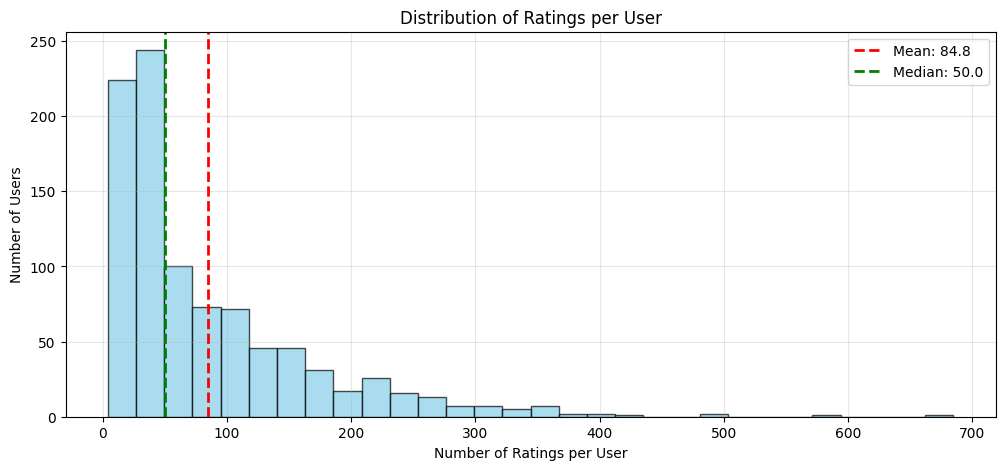

In [84]:
# Load the training data (using first fold as example)
train_data = getData(MOVIELENS_DIR, 'u1.base')

# Count ratings per user
ratings_per_user = train_data['userID'].value_counts()
rating_counts = ratings_per_user.values

# Create histogram
plt.figure(figsize=(12, 5))

# Regular histogram
plt.hist(rating_counts, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Ratings per User')
plt.grid(True, alpha=0.3)

# Add vertical lines for statistics
mean_ratings = np.mean(rating_counts)
median_ratings = np.median(rating_counts)
plt.axvline(mean_ratings, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_ratings:.1f}')
plt.axvline(median_ratings, color='green', linestyle='--', linewidth=2, label=f'Median: {median_ratings:.1f}')
plt.legend()

I have calculated the `median value` $\overline{x}$ which has precisely splitted my users in two halves based on how much activty they show. If I chose `50` as the threshold then it will be a `50/50` split. Based on my intuition, I will use  $\tau=70$ just to not be in the perfect middle but at the same time reflect real user behaviour pattern. Using this threshold, I will sperate split users as **active/power/enthusiastic** users who are movie enthusiastic and **iinactive/ cassual users** who do not engange that much in the platform for movie rating. Also, this value will be less than my `mean value` $\mu$. Thus, my choice follows the inequality: 

- $\overline{x} < \tau < \mu$

where $\overline{x} = 50, \tau = 70, \mu = 84.8$

Intuitively, my threshold of `70` means that users who have at least rated `70` movies or more are active/ power/ enthusiastic users and the rest are inactive/ cassual users.

In [85]:
# Setting up threshold and verify user split
tau = 70

# Load one fold to check the split
train_data = getData(MOVIELENS_DIR, 'u1.base')
ratings_per_user = train_data['userID'].value_counts()

# Check split
active_count = sum(ratings_per_user > tau)
inactive_count = sum(ratings_per_user <= tau)

print(f"Threshold τ = {tau}")
print(f"Active/ power/ enthusiastic users (>{tau} ratings): {active_count} ({active_count/943*100:.1f}%)")
print(f"Inactive/ cassual users (≤{tau} ratings): {inactive_count} ({inactive_count/943*100:.1f}%)")
print(f"Total users: {active_count + inactive_count}")

Threshold τ = 70
Active/ power/ enthusiastic users (>70 ratings): 382 (40.5%)
Inactive/ cassual users (≤70 ratings): 561 (59.5%)
Total users: 943


In [86]:
tau = 70

# Load one fold to check the split
train_data = getData(MOVIELENS_DIR, 'u1.base')
ratings_per_user = train_data['userID'].value_counts()

# Check split
active_count = sum(ratings_per_user > tau)
inactive_count = sum(ratings_per_user <= tau)
total_users = train_data.userID.nunique()

print(f"Threshold τ = {tau}")
print(f"Active/ power/ enthusiastic users (>{tau} ratings): {active_count} ({active_count/total_users*100:.1f}%)")
print(f"Inactive/ cassual users (≤{tau} ratings): {inactive_count} ({inactive_count/total_users*100:.1f}%)")

if (active_count + inactive_count) == total_users:
    print(f"Total users: {active_count + inactive_count}")

Threshold τ = 70
Active/ power/ enthusiastic users (>70 ratings): 382 (40.5%)
Inactive/ cassual users (≤70 ratings): 561 (59.5%)
Total users: 943


As we can see, my threshold **selection has given me a `40/60` split on power user and cassual user**. I did this because power users are providing me a lot of ratings and even if I create a small group of them, I am confident that their ratings will still be very relevant compared to the larger group of cassual users who less frequently rate a movie. Again, **active/ power/ enthusiastic users are actively engaging with the platoform which makes me think that their information is more "valuable" compared with the cassual users.**

In [87]:
# Helper functions

def get_user_activity_split(train_data, threshold):
    """Split users into active and inactive groups"""
    ratings_per_user = train_data['userID'].value_counts()
    
    active_users = set(ratings_per_user[ratings_per_user > threshold].index)
    inactive_users = set(ratings_per_user[ratings_per_user <= threshold].index)
    
    print(f"Split: {len(active_users)} active, {len(inactive_users)} inactive users")
    return active_users, inactive_users

def filter_test_by_users(test_data, user_set):
    """Filter test data to include only specified users"""
    filtered_data = test_data[test_data['userID'].isin(user_set)].copy()
    return filtered_data

def calculate_rmse(predictions, true_col='rating', pred_col=None):
    """Calculate RMSE between predicted and true ratings"""
    from math import sqrt
    from sklearn.metrics import mean_squared_error
    return sqrt(mean_squared_error(predictions[true_col], predictions[pred_col]))

print("Helper functions created successfully!")
active_users, inactive_users = get_user_activity_split(train_data, tau)

Helper functions created successfully!
Split: 382 active, 561 inactive users


In [88]:
# Set up the collaborative filtering algorithms

# Create the two CF recomendating systems
user_cosine_recsys = SimBasedRecSys(base='user', method='cosine')
item_cosine_recsys = SimBasedRecSys(base='item', method='cosine')

# Store in a list for easy iteration
algorithms = [user_cosine_recsys, item_cosine_recsys]
algorithm_names = ['User-User CF', 'Item-Item CF']

# Dataset parameters
num_users = 943
num_items = 1682

print("Algorithms ready for evaluation:")
for i, alg in enumerate(algorithms):
    print(f"{i+1}. {algorithm_names[i]}: {alg.getPredColName()}")

print(f"\nDataset: {num_users} users, {num_items} items")
print(f"Using threshold τ = {tau}")

Algorithms ready for evaluation:
1. User-User CF: user-cosine
2. Item-Item CF: item-cosine

Dataset: 943 users, 1682 items
Using threshold τ = 70


**I did the RMSE calculation for 5 folds in the dataset as given**

In [90]:
# Initialize results storage and load all folds

# Results storage
results = {
    'user-cosine': {'active': [], 'inactive': []},
    'item-cosine': {'active': [], 'inactive': []}
}

# Load 5 folds
folds = []
for i in range(1, 6):
    train_data = getData(MOVIELENS_DIR, f'u{i}.base')
    test_data = getData(MOVIELENS_DIR, f'u{i}.test')
    folds.append((train_data, test_data))

print("Data loading complete:")
print(f" Loaded {len(folds)} folds for cross-validation")
print(f" Results storage initialized for {len(algorithms)} algorithms")
print("\nReady to start evaluation")

Data loading complete:
 Loaded 5 folds for cross-validation
 Results storage initialized for 2 algorithms

Ready to start evaluation


In [93]:
# Run 5-fold cross-validation with chosen threshold of tau = 70

print("Starting 5-fold cross-validation...")
print("-------------------------------------")

# Run evaluation for each fold
for fold_idx, (train_data, test_data) in enumerate(folds):
    print(f"\n Fold {fold_idx + 1}/5:")
    print("-" * 20)
    
    # Split users by activity level based on training data
    active_users, inactive_users = get_user_activity_split(train_data, tau)
    
    # Filter test data for each user group
    test_active = filter_test_by_users(test_data, active_users)
    test_inactive = filter_test_by_users(test_data, inactive_users)
    
    print(f"Test data: {len(test_active)} active, {len(test_inactive)} inactive ratings")
    
    # Evaluate each algorithm
    for alg_idx, algorithm in enumerate(algorithms):
        alg_name = algorithm_names[alg_idx]
        print(f"\n  {alg_name}:")
        
        # Reset and train the algorithm
        algorithm.reset()
        algorithm.predict_all(train_data, num_users, num_items)
        
        # Get prediction column name
        pred_col = algorithm.getPredColName()
        
        # Evaluate on active users
        if len(test_active) > 0:
            predictions_active = algorithm.evaluate_test(test_active, copy=True)
            rmse_active = calculate_rmse(predictions_active, pred_col=pred_col)
            results[pred_col]['active'].append(rmse_active)
            print(f"    Active users RMSE:   {rmse_active:.4f}")
        
        # Evaluate on inactive users
        if len(test_inactive) > 0:
            predictions_inactive = algorithm.evaluate_test(test_inactive, copy=True)
            rmse_inactive = calculate_rmse(predictions_inactive, pred_col=pred_col)
            results[pred_col]['inactive'].append(rmse_inactive)
            print(f"    Inactive users RMSE: {rmse_inactive:.4f}")

print(f"\n Cross-validation completed!")
print("####################################")

Starting 5-fold cross-validation...
-------------------------------------

 Fold 1/5:
--------------------
Split: 382 active, 561 inactive users
Test data: 13511 active, 6489 inactive ratings

  User-User CF:


13511it [00:01, 7288.47it/s]


    Active users RMSE:   1.0162


6489it [00:00, 8119.30it/s]


    Inactive users RMSE: 1.0474

  Item-Item CF:


13511it [00:01, 8263.20it/s]


    Active users RMSE:   1.0248


6489it [00:00, 8343.53it/s]


    Inactive users RMSE: 1.0511

 Fold 2/5:
--------------------
Split: 392 active, 551 inactive users
Test data: 14956 active, 5044 inactive ratings

  User-User CF:


14956it [00:01, 8629.23it/s]


    Active users RMSE:   1.0104


5044it [00:00, 8593.46it/s]


    Inactive users RMSE: 1.0536

  Item-Item CF:


14956it [00:01, 8429.21it/s]


    Active users RMSE:   1.0131


5044it [00:00, 8460.30it/s]


    Inactive users RMSE: 1.0284

 Fold 3/5:
--------------------
Split: 380 active, 563 inactive users
Test data: 14343 active, 5657 inactive ratings

  User-User CF:


14343it [00:01, 8871.26it/s]


    Active users RMSE:   1.0034


5657it [00:00, 9518.80it/s]


    Inactive users RMSE: 1.0379

  Item-Item CF:


14343it [00:01, 9323.49it/s]


    Active users RMSE:   0.9904


5657it [00:00, 9032.10it/s]


    Inactive users RMSE: 1.0394

 Fold 4/5:
--------------------
Split: 373 active, 570 inactive users
Test data: 14249 active, 5751 inactive ratings

  User-User CF:


14249it [00:01, 9347.53it/s]


    Active users RMSE:   0.9992


5751it [00:00, 9623.37it/s]


    Inactive users RMSE: 1.0343

  Item-Item CF:


14249it [00:01, 9019.35it/s]


    Active users RMSE:   0.9967


5751it [00:00, 8458.71it/s]


    Inactive users RMSE: 1.0420

 Fold 5/5:
--------------------
Split: 370 active, 573 inactive users
Test data: 13061 active, 6939 inactive ratings

  User-User CF:


13061it [00:01, 8193.12it/s]


    Active users RMSE:   1.0010


6939it [00:00, 8641.63it/s]


    Inactive users RMSE: 1.0442

  Item-Item CF:


13061it [00:01, 9005.45it/s]


    Active users RMSE:   0.9997


6939it [00:00, 7345.35it/s]

    Inactive users RMSE: 1.0324

 Cross-validation completed!
####################################


Now we check the difference and their significance

In [94]:
# Calculate final statistics and analyze results

from scipy import stats

def calculate_stats(scores):
    """Calculate mean and 95% confidence interval"""
    if not scores:
        return None, None, None
    
    mean_score = np.mean(scores)
    if len(scores) > 1:
        ci_low, ci_high = stats.t.interval(0.95, len(scores)-1, 
                                          loc=mean_score, scale=stats.sem(scores))
    else:
        ci_low = ci_high = mean_score
    
    return mean_score, ci_low, ci_high

print("RMSE Results Summary:")
print("=========================")

final_results = {}

for alg_name, alg_results in results.items():
    print(f"\n{alg_name.upper()}:")
    print("-" * 40)
    
    final_results[alg_name] = {}
    
    # Active users
    active_scores = alg_results['active']
    active_mean, active_ci_low, active_ci_high = calculate_stats(active_scores)
    
    if active_mean is not None:
        print(f"Active users (>{tau} ratings):")
        print(f"  RMSE: {active_mean:.4f} (95% CI: {active_ci_low:.4f} - {active_ci_high:.4f})")
        print(f"  Fold scores: {[f'{score:.4f}' for score in active_scores]}")
        final_results[alg_name]['active'] = (active_mean, active_ci_low, active_ci_high, active_scores)
    
    # Inactive users  
    inactive_scores = alg_results['inactive']
    inactive_mean, inactive_ci_low, inactive_ci_high = calculate_stats(inactive_scores)
    
    if inactive_mean is not None:
        print(f"Inactive users (≤{tau} ratings):")
        print(f"  RMSE: {inactive_mean:.4f} (95% CI: {inactive_ci_low:.4f} - {inactive_ci_high:.4f})")
        print(f"  Fold scores: {[f'{score:.4f}' for score in inactive_scores]}")
        final_results[alg_name]['inactive'] = (inactive_mean, inactive_ci_low, inactive_ci_high, inactive_scores)
    
    # Calculate difference and statistical significance
    if active_mean is not None and inactive_mean is not None:
        difference = active_mean - inactive_mean
        print(f"\n  Difference (Active - Inactive): {difference:.4f}")
        
        if len(active_scores) > 1 and len(inactive_scores) > 1:
            t_stat, p_value = stats.ttest_ind(active_scores, inactive_scores)
            print(f"  T-test p-value: {p_value:.4f}")
            if p_value < 0.05:
                print("  Statistically significant difference (p < 0.05)")
            else:
                print("  No statistically significant difference (p ≥ 0.05)")

print("\n" + "#############################")

RMSE Results Summary:

USER-COSINE:
----------------------------------------
Active users (>70 ratings):
  RMSE: 1.0060 (95% CI: 0.9972 - 1.0149)
  Fold scores: ['1.0162', '1.0104', '1.0034', '0.9992', '1.0010']
Inactive users (≤70 ratings):
  RMSE: 1.0435 (95% CI: 1.0340 - 1.0530)
  Fold scores: ['1.0474', '1.0536', '1.0379', '1.0343', '1.0442']

  Difference (Active - Inactive): -0.0374
  T-test p-value: 0.0000
  Statistically significant difference (p < 0.05)

ITEM-COSINE:
----------------------------------------
Active users (>70 ratings):
  RMSE: 1.0050 (95% CI: 0.9877 - 1.0222)
  Fold scores: ['1.0248', '1.0131', '0.9904', '0.9967', '0.9997']
Inactive users (≤70 ratings):
  RMSE: 1.0387 (95% CI: 1.0277 - 1.0496)
  Fold scores: ['1.0511', '1.0284', '1.0394', '1.0420', '1.0324']

  Difference (Active - Inactive): -0.0337
  T-test p-value: 0.0018
  Statistically significant difference (p < 0.05)

#############################


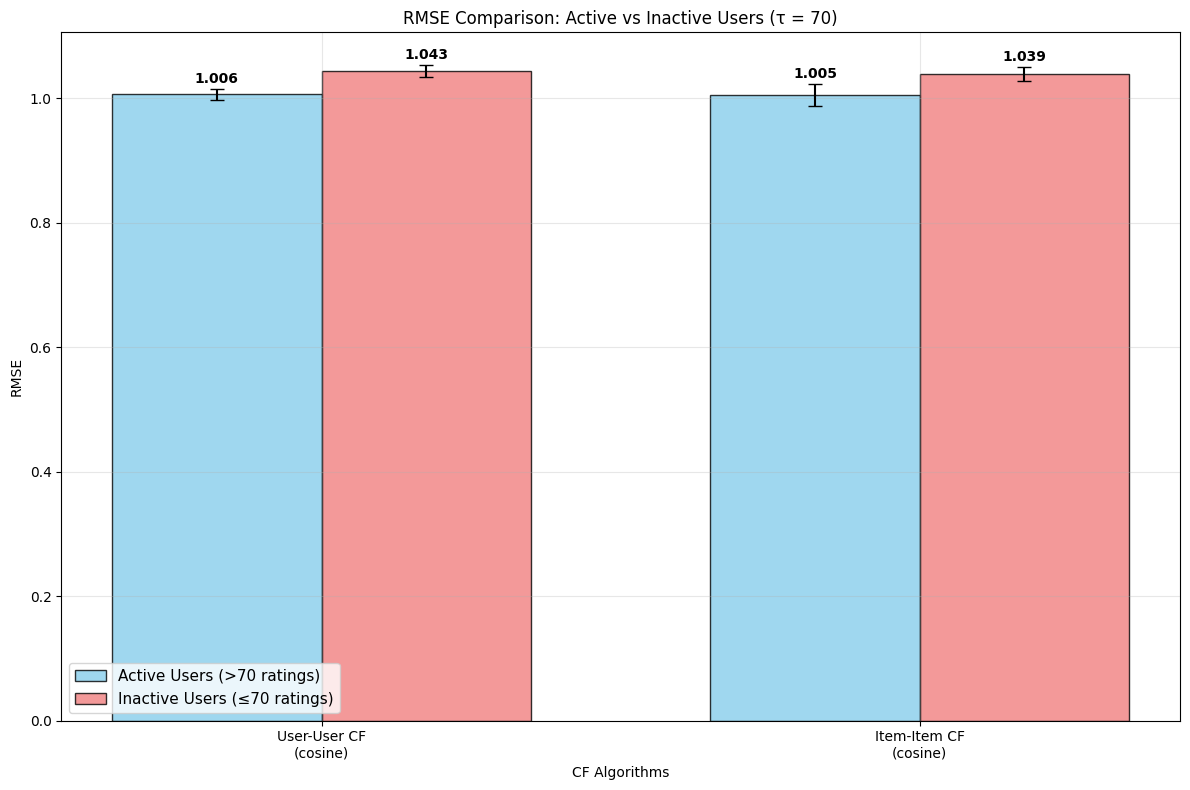

In [95]:
# Step 7: Visualization of the results
# Prepare data for plotting
algorithms_list = list(final_results.keys())
active_means = []
inactive_means = []
active_errors = []
inactive_errors = []

for alg in algorithms_list:
    # Active users data
    active_mean, active_ci_low, active_ci_high, _ = final_results[alg]['active']
    active_means.append(active_mean)
    active_errors.append([active_mean - active_ci_low, active_ci_high - active_mean])
    
    # Inactive users data
    inactive_mean, inactive_ci_low, inactive_ci_high, _ = final_results[alg]['inactive']
    inactive_means.append(inactive_mean)
    inactive_errors.append([inactive_mean - inactive_ci_low, inactive_ci_high - inactive_mean])

# Create the comparison plot
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(algorithms_list))
width = 0.35

# Convert error data for matplotlib
active_errors = np.array(active_errors).T
inactive_errors = np.array(inactive_errors).T

# Create bar chart
bars1 = ax.bar(x - width/2, active_means, width, label=f'Active Users (>{tau} ratings)', 
               yerr=active_errors, capsize=5, alpha=0.8, color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, inactive_means, width, label=f'Inactive Users (≤{tau} ratings)', 
               yerr=inactive_errors, capsize=5, alpha=0.8, color='lightcoral', edgecolor='black')

# Customize the plot
ax.set_xlabel('CF Algorithms', fontsize=10)
ax.set_ylabel('RMSE', fontsize=10)
ax.set_title(f'RMSE Comparison: Active vs Inactive Users (τ = {tau})', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(['User-User CF\n(cosine)', 'Item-Item CF\n(cosine)'])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add value labels on bars
def add_value_labels(bars, values, errors):
    for bar, value, error in zip(bars, values, errors.T):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + error[1] + 0.005,
               f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1, active_means, active_errors)
add_value_labels(bars2, inactive_means, inactive_errors)

plt.tight_layout()
plt.show()

In [98]:
# Print key findings summary

for idx, alg in enumerate(algorithms_list, start=1):
    active_mean = final_results[alg]['active'][0]
    inactive_mean = final_results[alg]['inactive'][0]
    improvement = ((inactive_mean - active_mean) / inactive_mean) * 100
    
    print(f"\n{idx} {alg.upper()}:")
    print(f"   Active users RMSE: {active_mean:.4f}")
    print(f"   Inactive users RMSE: {inactive_mean:.4f}")
    print(f"   Improvement/ reduction (if negative) for active users: {improvement:.1f}%")


1 USER-COSINE:
   Active users RMSE: 1.0060
   Inactive users RMSE: 1.0435
   Improvement/ reduction (if negative) for active users: 3.6%

2 ITEM-COSINE:
   Active users RMSE: 1.0050
   Inactive users RMSE: 1.0387
   Improvement/ reduction (if negative) for active users: 3.2%


#### Conclusion of Q6
Both our collaborative filtering approaches (`user-user`, `item-item`) demonstrate that user activity level significantly impacts recommendation and the information from active users yield lower RMSE score. This definately tempts me to come to the conclusion that users with richer interaction histories receive substantially better recommendations, with the effect being slightly more pronounced in user-based approaches due to their reliance on finding similar users. But we know that `RMSE` is not a reliable metric compared to the raking metrics (e.g., `P@K` or `R@K`) and it penalises the algorithm for every entries with equal importance rather than the top `k` reccoemndations and user's relevance. That is why we can not definitively give any verdict here.

# Validation

In [68]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [69]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [70]:
# validation_df = testDataPreprocessor()

validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [71]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [72]:
# testPopularityRecSys()

validatePopularityRecSys(validation_df)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
Max item popularity score: 1.0


### User Average Based Recommendation

In [73]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [74]:
# testPopularityRecSys()

validateUserAverRecSys

<function __main__.validateUserAverRecSys(validation_df=       userID  itemID  rating  timestamp
0           1       6       5  887431973
1           1      10       3  875693118
2           1      12       5  878542960
3           1      14       5  874965706
4           1      17       3  875073198
...       ...     ...     ...        ...
19995     458     648       4  886395899
19996     458    1101       4  886397931
19997     459     934       3  879563639
19998     460      10       3  882912371
19999     462     682       5  886365231

[20000 rows x 4 columns], BaseLineRecSys=<class '__main__.BaseLineRecSys'>)>

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [75]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [76]:
# testEuclidean()

validateEuclidean

<function __main__.validateEuclidean(validation_df=       userID  itemID  rating  timestamp
0           1       6       5  887431973
1           1      10       3  875693118
2           1      12       5  878542960
3           1      14       5  874965706
4           1      17       3  875073198
...       ...     ...     ...        ...
19995     458     648       4  886395899
19996     458    1101       4  886397931
19997     459     934       3  879563639
19998     460      10       3  882912371
19999     462     682       5  886365231

[20000 rows x 4 columns], getMatrix=<function CrossValidation.getMatrix at 0x000001B3F051CE00>)>

### Customized Similarity Function (test somethingelse function)

In [77]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [78]:
# testCustomizedSim()

validateCustomizedSim

<function __main__.validateCustomizedSim(validation_df=       userID  itemID  rating  timestamp
0           1       6       5  887431973
1           1      10       3  875693118
2           1      12       5  878542960
3           1      14       5  874965706
4           1      17       3  875073198
...       ...     ...     ...        ...
19995     458     648       4  886395899
19996     458    1101       4  886397931
19997     459     934       3  879563639
19998     460      10       3  882912371
19999     462     682       5  886365231

[20000 rows x 4 columns], getMatrix=<function CrossValidation.getMatrix at 0x000001B3F051CE00>)>

### User-User Similarity Based Recommendation System

In [79]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [80]:
# testUUSimBasedRecSys()

validateUUSimBasedRecSys

<function __main__.validateUUSimBasedRecSys(validation_df=       userID  itemID  rating  timestamp
0           1       6       5  887431973
1           1      10       3  875693118
2           1      12       5  878542960
3           1      14       5  874965706
4           1      17       3  875073198
...       ...     ...     ...        ...
19995     458     648       4  886395899
19996     458    1101       4  886397931
19997     459     934       3  879563639
19998     460      10       3  882912371
19999     462     682       5  886365231

[20000 rows x 4 columns], dataPreprocessor=<function dataPreprocessor at 0x000001B3F051E160>)>

### Item-Item Similarity Based Recommendation System

In [81]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [82]:
# testIISimBasedRecSys()

validateIISimBasedRecSys

<function __main__.validateIISimBasedRecSys(validation_df=       userID  itemID  rating  timestamp
0           1       6       5  887431973
1           1      10       3  875693118
2           1      12       5  878542960
3           1      14       5  874965706
4           1      17       3  875073198
...       ...     ...     ...        ...
19995     458     648       4  886395899
19996     458    1101       4  886397931
19997     459     934       3  879563639
19998     460      10       3  882912371
19999     462     682       5  886365231

[20000 rows x 4 columns], dataPreprocessor=<function dataPreprocessor at 0x000001B3F051E160>)>